# Проект: вариант 2
## Задание 1. A/B–тестирование

## 1.1 Условие

Одной из основных задач аналитика в нашей команде является корректное проведение экспериментов. Для этого мы применяем метод A/B–тестирования. В ходе тестирования одной гипотезы целевой группе была предложена новая механика оплаты услуг на сайте, у контрольной группы оставалась базовая механика. В качестве задания Вам необходимо проанализировать итоги эксперимента и сделать вывод, стоит ли запускать новую механику оплаты на всех пользователей.

## 1.2 Входные данные

В качестве входных данных Вы имеете 4 csv-файла:

groups.csv - файл с информацией о принадлежности пользователя к контрольной или экспериментальной группе (А – контроль, B – целевая группа) 

groups_add.csv - дополнительный файл с пользователями, который вам прислали спустя 2 дня после передачи данных

active_studs.csv - файл с информацией о пользователях, которые зашли на платформу в дни проведения эксперимента. 

checks.csv - файл с информацией об оплатах пользователей в дни проведения эксперимента. 

## 1.3 Вопросы

Предлагаем Вам ответить на следующие вопросы:

На какие метрики Вы смотрите в ходе анализа и почему?
Имеются ли различия в показателях и с чем они могут быть связаны?
Являются ли эти различия статистически значимыми?
Стоит ли запускать новую механику на всех пользователей?
Данный список вопросов не является обязательным, и Вы можете при своём ответе опираться на собственный план.


In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as st
import numpy as np
from scipy.stats import bootstrap

large = 22; med = 16; small = 12
params = {'axes.titlesize': large,
          'legend.fontsize': med,
          'figure.figsize': (16, 10),
          'axes.labelsize': med,
          'axes.titlesize': med,
          'xtick.labelsize': med,
          'ytick.labelsize': med,
          'figure.titlesize': large}
plt.rcParams.update(params)
plt.style.use('seaborn-whitegrid')
sns.set_style("white")
%matplotlib inline

In [4]:
groups = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-da-gerasimov/final_project/groups.csv',sep = ';')
checks = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-da-gerasimov/final_project/checks.csv',sep = ';')
group_add = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-da-gerasimov/final_project/group_add.csv',sep = ',')
active_studs = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-da-gerasimov/final_project/active_studs.csv')

Проверяем данные на НаНы и на дубли

In [5]:
groups.isnull().sum()

id     0
grp    0
dtype: int64

In [6]:
checks.isnull().sum()

student_id    0
rev           0
dtype: int64

In [7]:
group_add.isnull().sum()

id     0
grp    0
dtype: int64

In [8]:
active_studs.isnull().sum()

student_id    0
dtype: int64

In [9]:
groups.duplicated().value_counts()

False    74484
dtype: int64

In [10]:
checks.duplicated().value_counts()

False    541
dtype: int64

In [11]:
group_add.duplicated().value_counts()

False    92
dtype: int64

In [12]:
active_studs.duplicated().value_counts()

False    8341
dtype: int64

In [13]:
all_groups = pd.concat([groups, group_add], ignore_index=True) #Объединяем данные в один датафрейм

In [14]:
all_groups.groupby('grp',as_index = False).size() #Смотрим размеры групп

,grp,size
0,A,14693
1,B,59883


In [15]:
all_groups = all_groups.rename(columns = {'id':'student_id'}) #Переименовываем колонку для удобства джоина

In [16]:
active = active_studs.merge(all_groups) #Джоиним данные и получаем только те, которые были получены в дни эксперимента

In [17]:
active.groupby('grp',as_index = False).size() #Смотрим размеры групп

,grp,size
0,A,1538
1,B,6803


In [18]:
tested = active.merge(checks,on = 'student_id',how='left').fillna(0) 
#Джоиним данные с оплатами и заполняем НаНы нулями

Основные две метрики, которые в моем понимании нужно смотреть - это конверсия в покупку и средний чек.

## Гипотеза: новая механика влияет на конверсию в покупку. Нулевая гипотеза: новая механика не влияет на конверсию в покупку

In [19]:
    bought = tested.query('rev > 0') \
    .groupby('grp',as_index = False) \
    .agg({'rev':'count'}) \
    .rename(columns = {'rev':'users_bought'})
    
    alltested = tested.groupby('grp',as_index = False) \
    .agg({'rev':'count'}) \
    .rename(columns = {'rev':'alltested'})
    
    CR = bought.users_bought/alltested.alltested * 100
    CR

0    5.071521
1    4.615611
dtype: float64

Видим что конверсия уменьшилась, проверим, статзначимо ли изменение.
Проверять будем через хи-квадрат.

In [20]:
df_metrics = bought.merge(alltested, on = 'grp')
df_metrics['not_bought'] = alltested.alltested - bought.users_bought
df_metrics

,grp,users_bought,alltested,not_bought
0,A,78,1538,1460
1,B,314,6803,6489


In [21]:
st.chi2_contingency(df_metrics[['users_bought','not_bought']])

(0.48480826522557896,
 0.48625240457231045,
 1,
 array([[  72.28102146, 1465.71897854],
        [ 319.71897854, 6483.28102146]]))

P-value 0.48, что говорит нам о том, что изменения не статзначимы.

Принимаем нулевую гипотезу,которая гласит: новая механика не влияет на конверсию в покупку

## Гипотеза: новая механика влияет на средний чек. Нулевая гипотеза: новая механика не влияет на средний чек

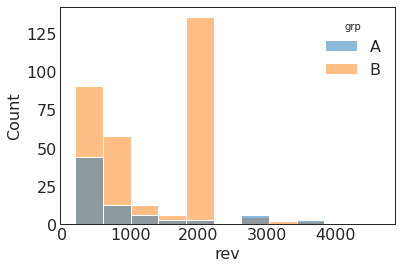

In [22]:
sns.histplot(data=tested.query('rev > 0'),x = 'rev',hue = 'grp') ## Строим график покупок, видим ненормальное распределение.

In [23]:
    AverageCheck = tested.query('rev > 0') \
    .groupby('grp') \
    .agg({'rev':'mean'}) \
    .rename(columns = {'rev':'AverageCheck'})
    AverageCheck

,AverageCheck
grp,
A,933.589744
B,1257.878992


Видим, что средний чек по факту выше в тестовой группе. Проверим на статзначимость. Будем использовать бутстрэп.

In [24]:
control_df = tested.query('rev > 0 & grp == "A"')
exp_df = tested.query('rev > 0 & grp == "B"')
## Разделяем группы для бутстрэпа

In [25]:
bootstrap((exp_df.rev, ),np.mean, confidence_level=0.95,
                         random_state=1)

BootstrapResult(confidence_interval=ConfidenceInterval(low=1174.8124811576436, high=1348.1078373206321), standard_error=44.23523624205667)

In [26]:
bootstrap((control_df.rev, ),np.mean, confidence_level=0.95,
                         random_state=1)

BootstrapResult(confidence_interval=ConfidenceInterval(low=757.2183484477607, high=1169.8919239951833), standard_error=103.33991629093181)

Т.к. интервалы не пересекаются, можно сделать вывод, что разница в группах по среднему чеку статзначима

Это можно проверить вручную, если между 5 и 95 квантилем не будет 0, то разница статзначима. 

In [27]:
mean_diff = []

for i in range(10000):
    sample_data_control = control_df.sample(frac=1, replace=True)
    sample_mean_control = sample_data_control.rev.mean()
    
    
    sample_data_exp = exp_df.sample(frac=1, replace=True)
    sample_mean_exp = sample_data_exp.rev.mean()
    
    sample_mean_diff = sample_mean_exp - sample_mean_control
    mean_diff.append(sample_mean_diff)

## Ищем разницу между полученными значениями

In [28]:
pd.Series(mean_diff).quantile(0.975) ## Ищем верхний квантиль

534.8579091868774

In [29]:
pd.Series(mean_diff).quantile(0.025) ## Ищем нижний квантиль

94.1993503111221

Между квантилями нет нуля. Делаем вывод, что результат статзначим.

Принимаем гипотезу: новая механика влияет на средний чек

### Вывод: Снижение конверсии в тестовой группе не является статзначимым, а увеличение чека в тестовой группе является статзначимым.
## Следовательно новую механику оплаты стоит запускать на всех пользователей.